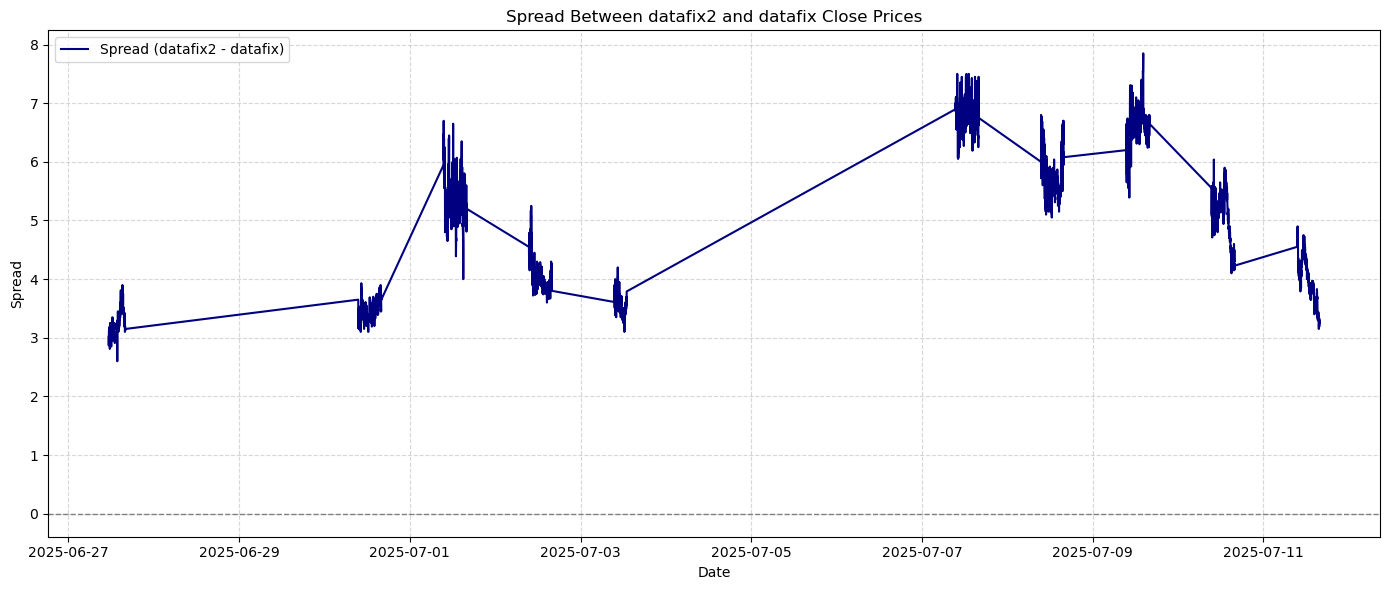

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001445. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Buy model:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       657
           1       0.46      0.10      0.16        63

    accuracy                           0.91       720
   macro avg       0.69      0.54      0.56       720
weighted avg       0.88      0.91      0.88       720

Sell model:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       627
           1       0.57      0.09      0.15        93

    accuracy                           0.87       720
   macro avg       0.73      0.54      0.54       720
weighted avg       0.84      0.87      0.83       720

Combined_Signal
hold    3263
sell     199
buy      138
Name: count, dtype: int64


In [16]:
import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.stats import norm
from scipy.optimize import brentq
import pandas_datareader.data as web
import datetime
# Random forest settings 
buy_thresh = 0.6  # Threshold for buy signal(probability of rf outcome) df.2
sell_thresh = -0.6  # Threshold for sell signal(probability of rf outcome) df-.2
neighbors = 10
backtest_ma = 1 # Buy/sell moving average for rolling RF signal and backtest | keep same as stat window df20
# --- PARAMETERS ---
numbars = 3600
durationStr = '7 D'
barSizeSetting = '1 min'

# Leg 1
symbol1 = 'TSLA'
lastTradeDateOrContractMonth1 = '20250718'
strike1 = 310
right1 = 'P'

# Leg 2
symbol2 = 'TSLA'
lastTradeDateOrContractMonth2 = '20250718'
strike2 = 300
right2 = 'P'

# --- FETCH FUNCTION ---
async def fetch_option(symbol, lastTradeDateOrContractMonth, strike, right, num_bars):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7496, clientId=np.random.randint(1000, 10000))

    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)

    stock_contract = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock_contract)

    all_bars = []
    end_time = ''
    while len(all_bars) < num_bars:
        bars = await ib.reqHistoricalDataAsync(
            contract=option_contract,
            endDateTime=end_time,
            durationStr=durationStr,
            barSizeSetting=barSizeSetting,
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        if not bars:
            print("No more bars available.")
            break
        all_bars = bars + all_bars
        end_time = (bars[0].date - pd.Timedelta(minutes=1)).strftime('%Y%m%d %H:%M:%S')
        await asyncio.sleep(10)
    all_bars = all_bars[-num_bars:]
    df = util.df(all_bars)
    df.set_index('date', inplace=True)

    stock_bars = await ib.reqHistoricalDataAsync(
        contract=stock_contract,
        endDateTime='',
        durationStr=durationStr,
        barSizeSetting=barSizeSetting,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    stock_df = util.df(stock_bars)
    stock_df.set_index('date', inplace=True)

    df['stock price'] = stock_df['close'].reindex(df.index, method='ffill')

    # Capitalize columns
    df.rename(columns={
        'close': 'Close',
        'volume': 'Volume',
        'stock price': 'Stock Price'
    }, inplace=True)

    ib.disconnect()
    return df

# --- GET RISK-FREE RATE ---
start = datetime.datetime(2025, 6, 1)
end = datetime.datetime(2025, 6, 9)
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar

# --- FETCH DATA FOR BOTH LEGS ---
datafix = await fetch_option(symbol1, lastTradeDateOrContractMonth1, strike1, right1, numbars)
datafix2 = await fetch_option(symbol2, lastTradeDateOrContractMonth2, strike2, right2, numbars)

# --- PROCESS EACH DATAFRAME ---
def process_option_df(df, strike, right, lastTradeDateOrContractMonth, rfr):
    # Kalman Filter
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([df['Close'].iloc[0], 0.])
    kf.F = np.array([[1., .1], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 1.
    kf.Q = np.eye(2)*0.05

    filtered_state_means = []
    for price in df['Close']:
        kf.predict()
        kf.update(price)
        filtered_state_means.append(kf.x[0])
    df['Kalman'] = filtered_state_means

    df["Kalman_Roc"] = df['Kalman'].pct_change() * 100

    # MACD
    def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
        ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
        ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        macd_hist = macd - signal_line
        df['MACD'] = macd
        df['Signal'] = signal_line
        df['MACD_Hist'] = macd_hist
        return df

    df = calculate_macd(df)

    # Expiry and days to expiry
    expiry = pd.Timestamp(lastTradeDateOrContractMonth)
    df.index = df.index.tz_localize(None)
    df['days_to_expiry'] = (expiry - df.index).days.astype(float) + 1

    # Black-Scholes inputs
    df['strike'] = strike
    df['rfr'] = rfr / 100
    df['type'] = right.lower()

    # Black-Scholes IV calculation
    def black_scholes_price(S, K, T, r, sigma, option_type):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'c':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def implied_volatility_row(row):
        price = row['Close']
        S = row['Stock Price']
        K = row['strike']
        T = row['days_to_expiry'] / 365.0
        r = row['rfr']
        option_type = row['type']
        def objective(sigma):
            return black_scholes_price(S, K, T, r, sigma, option_type) - price
        try:
            return brentq(objective, 1e-6, 5.0)
        except Exception:
            return np.nan

    df['IV'] = df.apply(implied_volatility_row, axis=1)
    df["IVROC"] = df["IV"].pct_change() * 100
    return df

datafix = process_option_df(datafix, strike1, right1, lastTradeDateOrContractMonth1, rfr)
datafix2 = process_option_df(datafix2, strike2, right2, lastTradeDateOrContractMonth2, rfr)

# --- Now you have both datafix and datafix2 ready for further analysis ---
import matplotlib.pyplot as plt

# Calculate the spread
datafix["spread"] = datafix["Close"] - datafix2["Close"]

# Plot the spread
plt.figure(figsize=(14, 6))
plt.plot(datafix.index, datafix["spread"], label="Spread (datafix2 - datafix)", color='navy')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Spread Between datafix2 and datafix Close Prices")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
from scipy.stats import norm

# --- Black-Scholes Greeks calculation (without Rho) ---
def bs_greeks(S, K, T, r, sigma, option_type):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan, np.nan, np.nan, np.nan  # Handle invalid/missing data
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    else:
        delta = norm.cdf(d1) - 1
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return delta, gamma, vega, theta

r = 0.05  # Risk-free rate

def calc_row_greeks(row):
    S = row['Stock Price']
    K = row['strike']
    T = max(row['days_to_expiry'] / 365, 1e-6)  # Avoid division by zero
    sigma = row['IV']
    option_type = row['type'].lower()
    return bs_greeks(S, K, T, r, sigma, option_type)

# --- Apply to datafix ---
greeks1 = datafix.apply(calc_row_greeks, axis=1, result_type='expand')
greeks1.columns = ['delta', 'gamma', 'vega', 'theta']
datafix = pd.concat([datafix, greeks1], axis=1)

# --- Apply to datafix2 ---
greeks2 = datafix2.apply(calc_row_greeks, axis=1, result_type='expand')
greeks2.columns = ['delta', 'gamma', 'vega', 'theta']
datafix2 = pd.concat([datafix2, greeks2], axis=1)
from arch import arch_model
import numpy as np

# --- For datafix ---
iv_series = pd.to_numeric(datafix['IV'], errors='coerce')
iv_series = iv_series.replace([np.inf, -np.inf], np.nan).dropna()

if len(iv_series) > 10:  # GARCH needs enough data points
    model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    conditional_vol = model_fit.conditional_volatility
    # Fill NaN in the original DataFrame, align by index
    datafix['IV_garch_vol'] = np.nan
    datafix.loc[conditional_vol.index, 'IV_garch_vol'] = conditional_vol
else:
    datafix['IV_garch_vol'] = np.nan

# --- For datafix2 (with suffix '2') ---
iv_series2 = pd.to_numeric(datafix2['IV'], errors='coerce')
iv_series2 = iv_series2.replace([np.inf, -np.inf], np.nan).dropna()

if len(iv_series2) > 10:
    model2 = arch_model(iv_series2, mean='Zero', vol='GARCH', p=1, q=1)
    model_fit2 = model2.fit(disp='off')
    conditional_vol2 = model_fit2.conditional_volatility
    datafix2['IV_garch_vol'] = np.nan
    datafix2.loc[conditional_vol2.index, 'IV_garch_vol'] = conditional_vol2
else:
    datafix2['IV_garch_vol'] = np.nan

import pandas as pd

def compute_rsi(df, column="Close", period=14, rsi_col="RSI"):
    delta = df[column].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df[rsi_col] = rsi
    return df

# For datafix
datafix = compute_rsi(datafix, column="Close", period=14, rsi_col="RSI")
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()

# For datafix2, with suffix '2'
datafix2 = compute_rsi(datafix2, column="Close", period=14, rsi_col="RSI")
datafix2['rsiMA_14'] = datafix2['RSI'].rolling(window=14).mean()
import pandas as pd

def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9, suffix=''):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df[f'MACDvol{suffix}'] = macd
    df[f'Signalvol{suffix}'] = signal_line
    df[f'MACD_Histvol{suffix}'] = macd_hist
    df[f'MACDROCvol{suffix}'] = macd_hist.pct_change()
    return df

# Calculate MACD features for both dataframes
datafix = calculate_macd(datafix, close_col='IV_garch_vol', suffix='')
datafix2 = calculate_macd(datafix2, close_col='IV_garch_vol', suffix='')

# Combine all columns from both dataframes, aligning by index
datafix_combined = pd.concat([datafix, datafix2], axis=1)
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9, suffix=''):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df[f'MACDkalman{suffix}'] = macd
    df[f'Signalkalman{suffix}'] = signal_line
    df[f'MACD_Histkalman{suffix}'] = macd_hist
    df[f'MACDROCkal{suffix}'] = macd_hist.pct_change()
    return df

# Apply to datafix
datafix = calculate_macd(datafix, close_col='Kalman', suffix='')

# Apply to datafix2, with '2' suffix
datafix2 = calculate_macd(datafix2, close_col='Kalman', suffix='')

# If you want to combine all columns into one DataFrame (optional):
#datafix_combined = pd.concat([datafix, datafix2], axis=1)
lag = 9

# For datafix
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()
datafix["stocktrend"] = datafix["Stock Price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"]
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

# For datafix2, with suffix '2'
datafix2["Kalman_Roc_roll"] = datafix2["Kalman_Roc"].rolling(lag).mean()
datafix2["MACDROCvolroll9"] = datafix2["MACDROCvol"].rolling(9).mean()
datafix2["MACDROCkalroll9"] = datafix2["MACDROCkal"].rolling(9).mean()
datafix2["stocktrend"] = datafix2["Stock Price"].pct_change().rolling(3).mean()
datafix2["sma30"] = datafix2["Close"].rolling(20).mean()
datafix2["smaspread"] = datafix2["sma30"] - datafix2["Close"]
datafix2["IV_garch_volsma"] = datafix2['IV_garch_vol'].pct_change().rolling(18).mean()
datafix2["kalmansma"] = datafix2['Kalman'].pct_change().rolling(5).mean()

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- 1. Feature List ---
feature_list = [
    'Close', 'Volume', 'Kalman', 'Kalman_Roc', 'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry',
    'Stock Price', 'strike', 'rfr', 'IV', 'IVROC', 'delta', 'gamma', 'vega', 'theta',
    'IV_garch_vol', 'RSI', 'rsiMA_14', 'MACDvol', 'Signalvol', 'MACD_Histvol',
    'MACDROCvol', 'MACDkalman', 'Signalkalman', 'MACD_Histkalman', 'MACDROCkal', 'Kalman_Roc_roll',
    'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend', 'sma30', 'smaspread', 'IV_garch_volsma',
    'kalmansma'
]

# --- 2. Prepare Features (for both training and prediction) ---
features_fix1 = datafix[feature_list].add_suffix('_fix1')
features_fix2 = datafix2[feature_list].add_suffix('_fix2')
features_df = pd.concat([features_fix1, features_fix2], axis=1)

# --- 3. Labeling Functions ---
def forward_local_extrema(series, order, mode='min'):
    idxs = []
    n = len(series)
    for i in range(n - order):
        window = series[i+1:i+order+1]
        if mode == 'min':
            if np.all(series[i] < window):
                idxs.append(i)
        elif mode == 'max':
            if np.all(series[i] > window):
                idxs.append(i)
    return np.array(idxs)



# --- 4. Build Buy Labels (local minima on spread) ---
min_idx = forward_local_extrema(datafix['spread'].values, neighbors, mode='min')
y_buy = np.zeros(len(features_df), dtype=int)
y_buy[min_idx] = 1

# --- 5. Build Sell Labels (local maxima on spread) ---
max_idx = forward_local_extrema(datafix['spread'].values, neighbors, mode='max')
y_sell = np.zeros(len(features_df), dtype=int)
y_sell[max_idx] = 1

# --- 6. Train/Test Split (optional, for evaluation) ---
X_train, X_test, y_buy_train, y_buy_test = train_test_split(features_df, y_buy, test_size=0.2, random_state=42)
_, _, y_sell_train, y_sell_test = train_test_split(features_df, y_sell, test_size=0.2, random_state=42)

# --- 7. Train Buy Model ---
hgb_buy = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgb_buy.fit(X_train, y_buy_train)
print("Buy model:")
print(classification_report(y_buy_test, hgb_buy.predict(X_test)))

# --- 8. Train Sell Model ---
hgb_sell = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42
)
hgb_sell.fit(X_train, y_sell_train)
print("Sell model:")
print(classification_report(y_sell_test, hgb_sell.predict(X_test)))

# --- 9. Get Buy and Sell Probabilities for ALL ROWS ---
datafix["Buy_Prob"] = hgb_buy.predict_proba(features_df)[:, 1]
datafix["Sell_Prob"] = hgb_sell.predict_proba(features_df)[:, 1]

# --- 10. Compute Combined Score ---
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]



def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

# --- 12. Apply Signal Logic ---
datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)

# --- 13. (Optional) Display Signal Counts ---
print(datafix["Combined_Signal"].value_counts())
import plotly.graph_objects as go

fig = go.Figure()

# Close price from datafix (main)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["Close"],
    mode='lines', name='Close (fix1)', line=dict(color='red', dash='dot', width=2)
))

# Close price from datafix2
fig.add_trace(go.Scatter(
    x=datafix2.index, y=datafix2["Close"],
    mode='lines', name='Close (fix2)', line=dict(color='blue', width=2, dash='dot')
))

# Spread (from datafix)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["spread"],
    mode='lines', name='Spread', line=dict(color='black', width=2)
))

# Combined buy signals (green upward triangle) ON SPREAD
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=buy_signals["spread"],
    mode='markers', name='Combined Buy (on spread)',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))

# Combined sell signals (red downward triangle) ON SPREAD
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=sell_signals["spread"],
    mode='markers', name='Combined Sell (on spread)',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.7)
split_date_bar = datafix.index[split_idx_bar]
fig.add_vline(x=split_date_bar, line=dict(color='black', dash='dash', width=2))

# Layout settings
fig.update_layout(
    title="Close Prices (fix1, fix2), Spread, and Combined Buy/Sell Signals (on Spread)",
    xaxis_title="Date",
    yaxis_title="Price / Spread",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


In [17]:
import plotly.graph_objects as go

fig = go.Figure()

# Close price from datafix (main)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["Close"],
    mode='lines', name='Close (fix1)', line=dict(color='red', dash='dot', width=2)
))

# Close price from datafix2
fig.add_trace(go.Scatter(
    x=datafix2.index, y=datafix2["Close"],
    mode='lines', name='Close (fix2)', line=dict(color='blue', width=2, dash='dot')
))

# Spread (from datafix)
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["spread"],
    mode='lines', name='Spread', line=dict(color='black', width=2)
))

# Combined buy signals (green upward triangle) ON SPREAD
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=buy_signals["spread"],
    mode='markers', name='Combined Buy (on spread)',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))

# Combined sell signals (red downward triangle) ON SPREAD
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=sell_signals["spread"],
    mode='markers', name='Combined Sell (on spread)',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.7)
split_date_bar = datafix.index[split_idx_bar]
fig.add_vline(x=split_date_bar, line=dict(color='black', dash='dash', width=2))

# Layout settings
fig.update_layout(
    title="Close Prices (fix1, fix2), Spread, and Combined Buy/Sell Signals (on Spread)",
    xaxis_title="Date",
    yaxis_title="Price / Spread",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


In [18]:
import numpy as np

async def fetch_new_option_data(symbol, lastTradeDateOrContractMonth, strike, right, barSizeSetting, durationStr, last_timestamp):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7496, clientId=np.random.randint(1000, 10000))

    option_contract = Option(
        symbol=symbol,
        lastTradeDateOrContractMonth=lastTradeDateOrContractMonth,
        strike=strike,
        right=right,
        exchange='SMART',
        currency='USD'
    )
    await ib.qualifyContractsAsync(option_contract)

    stock_contract = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock_contract)

    # Fetch option bars
    bars = await ib.reqHistoricalDataAsync(
        contract=option_contract,
        endDateTime='',  # now
        durationStr=durationStr,
        barSizeSetting=barSizeSetting,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    df = util.df(bars)
    df.set_index('date', inplace=True)
    # --- TIMEZONE FIX ---
    df.index = df.index.tz_localize(None)
    if hasattr(last_timestamp, 'tzinfo') and last_timestamp.tzinfo is not None:
        last_timestamp = last_timestamp.tz_convert(None)
    df = df[df.index > last_timestamp]

    # Fetch stock bars
    stock_bars = await ib.reqHistoricalDataAsync(
        contract=stock_contract,
        endDateTime='',
        durationStr=durationStr,
        barSizeSetting=barSizeSetting,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    stock_df = util.df(stock_bars)
    stock_df.set_index('date', inplace=True)
    stock_df.index = stock_df.index.tz_localize(None)
    stock_df = stock_df[stock_df.index > last_timestamp]

    # Align stock price to option bars
    df['stock price'] = stock_df['close'].reindex(df.index, method='ffill')
    df.rename(columns={'close': 'Close', 'volume': 'Volume', 'stock price': 'Stock Price'}, inplace=True)

    ib.disconnect()
    return df

# --- 1. Get last timestamp from your original data ---
last_timestamp = datafix.index[-1]
if hasattr(last_timestamp, 'tzinfo') and last_timestamp.tzinfo is not None:
    last_timestamp = last_timestamp.tz_convert(None)

# --- 2. Fetch and process new data since last_timestamp ---
new_datafix = await fetch_new_option_data(
    symbol1, lastTradeDateOrContractMonth1, strike1, right1, barSizeSetting, durationStr, last_timestamp
)
new_datafix2 = await fetch_new_option_data(
    symbol2, lastTradeDateOrContractMonth2, strike2, right2, barSizeSetting, durationStr, last_timestamp
)

if len(new_datafix) == 0 or len(new_datafix2) == 0:
    print("No new data since last run.")
else:
    new_datafix = process_option_df(new_datafix, strike1, right1, lastTradeDateOrContractMonth1, rfr)
    new_datafix2 = process_option_df(new_datafix2, strike2, right2, lastTradeDateOrContractMonth2, rfr)
    new_datafix["spread"] = new_datafix["Close"] - new_datafix2["Close"]

    # --- 3. Fill missing/rolling features with last value from previous data ---
    for col in feature_list:
        if col not in new_datafix.columns:
            if col in datafix.columns:
                new_datafix[col] = datafix[col].iloc[-1]
            else:
                new_datafix[col] = np.nan
        new_datafix[col] = new_datafix[col].fillna(datafix[col].iloc[-1] if col in datafix.columns else np.nan)
        if col not in new_datafix2.columns:
            if col in datafix2.columns:
                new_datafix2[col] = datafix2[col].iloc[-1]
            else:
                new_datafix2[col] = np.nan
        new_datafix2[col] = new_datafix2[col].fillna(datafix2[col].iloc[-1] if col in datafix2.columns else np.nan)

    # --- 4. Prepare features for prediction ---
    new_features_fix1 = new_datafix[feature_list].add_suffix('_fix1')
    new_features_fix2 = new_datafix2[feature_list].add_suffix('_fix2')
    new_features_df = pd.concat([new_features_fix1, new_features_fix2], axis=1)

    # --- 5. Predict using trained models ---
    new_datafix["Buy_Prob"] = hgb_buy.predict_proba(new_features_df)[:, 1]
    new_datafix["Sell_Prob"] = hgb_sell.predict_proba(new_features_df)[:, 1]
    new_datafix["Combined_Score"] = new_datafix["Buy_Prob"] - new_datafix["Sell_Prob"]

    def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
        if score > buy_thresh:
            return "buy"
        elif score < sell_thresh:
            return "sell"
        else:
            return "hold"
    new_datafix["Combined_Signal"] = new_datafix["Combined_Score"].apply(weighted_signal)

    # --- 6. Plot in Plotly ---
    import plotly.graph_objects as go

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=new_datafix.index, y=new_datafix["Close"],
        mode='lines', name='Close (fix1)', line=dict(color='red', dash='dot', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=new_datafix2.index, y=new_datafix2["Close"],
        mode='lines', name='Close (fix2)', line=dict(color='blue', width=2, dash='dot')
    ))
    fig.add_trace(go.Scatter(
        x=new_datafix.index, y=new_datafix["spread"],
        mode='lines', name='Spread', line=dict(color='black', width=2)
    ))
    buy_signals = new_datafix[new_datafix["Combined_Signal"] == "buy"]
    fig.add_trace(go.Scatter(
        x=buy_signals.index, y=buy_signals["spread"],
        mode='markers', name='Combined Buy (on spread)',
        marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
    ))
    sell_signals = new_datafix[new_datafix["Combined_Signal"] == "sell"]
    fig.add_trace(go.Scatter(
        x=sell_signals.index, y=sell_signals["spread"],
        mode='markers', name='Combined Sell (on spread)',
        marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
    ))
    fig.update_layout(
        title="New Data: Close Prices (fix1, fix2), Spread, and Combined Buy/Sell Signals (on Spread)",
        xaxis_title="Date",
        yaxis_title="Price / Spread",
        legend=dict(x=0.01, y=0.99),
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=500
    )
    fig.show()


Total Strategy $ Return (Last 30%): $985.00


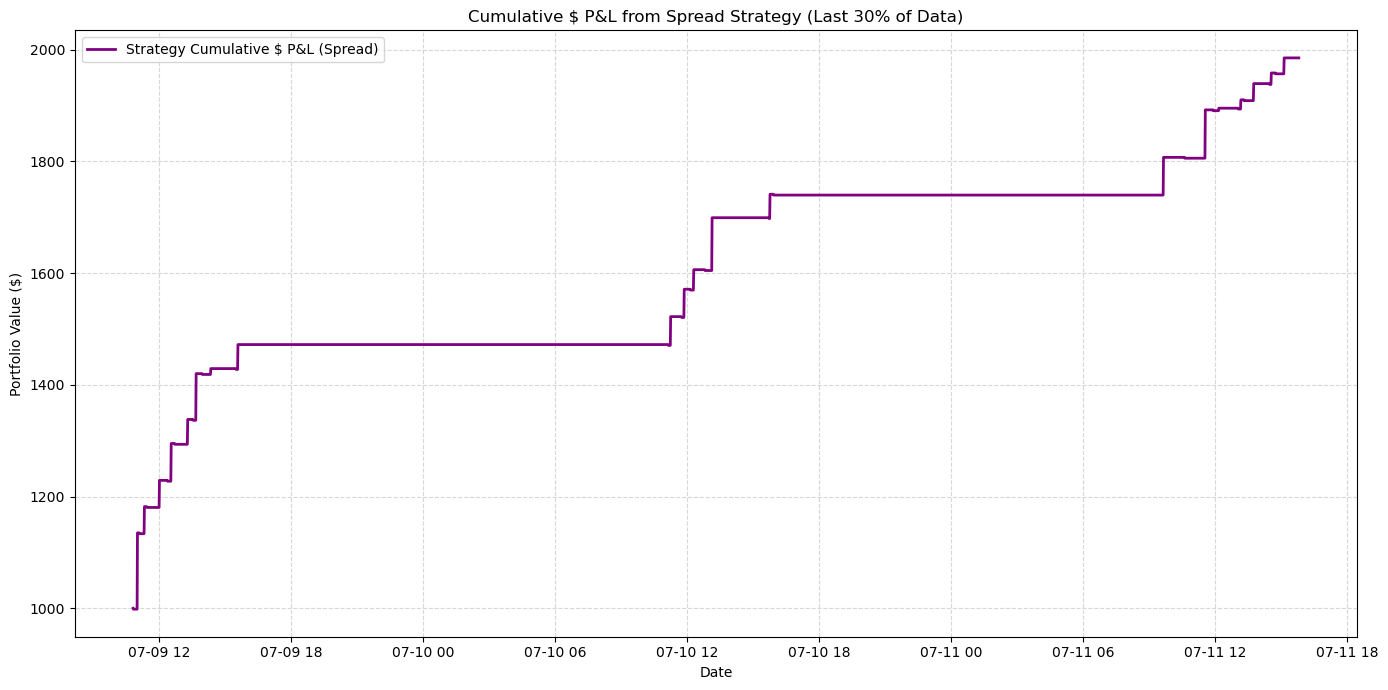

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Map 'buy' to 1, 'sell' to -1
datafix['Trade_Signal1'] = datafix['Combined_Signal'].map({'buy': 1, 'sell': -1})

# --- 1. Slice the last 30% of the data ---
start_idx = int(len(datafix) * 0.7)
datafix_last30 = datafix.iloc[start_idx:].copy()

# --- 2. Initialize variables ---
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_spread = None
fee = 1.50  # set to a dollar fee per trade if desired

# --- 3. Backtest loop: $ P&L on spread (spread is in 100s of $) ---
for idx, row in datafix_last30.iterrows():
    signal = row['Trade_Signal1']
    spread = row['spread']

    # Enter trade: record entry spread
    if signal == 1 and position == 0:
        position = 1
        entry_spread = spread
        capital -= fee  # optional: subtract entry fee

    # Exit trade: calculate P&L as $ change in spread (scaled)
    elif signal == -1 and position == 1:
        pnl = (spread - entry_spread) * 100  # scale by 100
        capital += pnl
        capital -= fee  # optional: subtract exit fee
        position = 0
        entry_spread = None

    # Portfolio value: capital (no open P&L on current spread)
    portfolio.append(capital)
    positions.append(position)

# --- 4. Attach results ---
datafix_last30['Position'] = positions
datafix_last30['Portfolio'] = portfolio

# --- 5. Print final results ---
total_return = datafix_last30['Portfolio'].iloc[-1] - initial_capital
print(f"Total Strategy $ Return (Last 30%): ${total_return:.2f}")

# --- 6. Plot ---
plt.figure(figsize=(14, 7))
plt.plot(datafix_last30.index, datafix_last30['Portfolio'], label='Strategy Cumulative $ P&L (Spread)', color='purple', linewidth=2)
plt.title('Cumulative $ P&L from Spread Strategy (Last 30% of Data)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


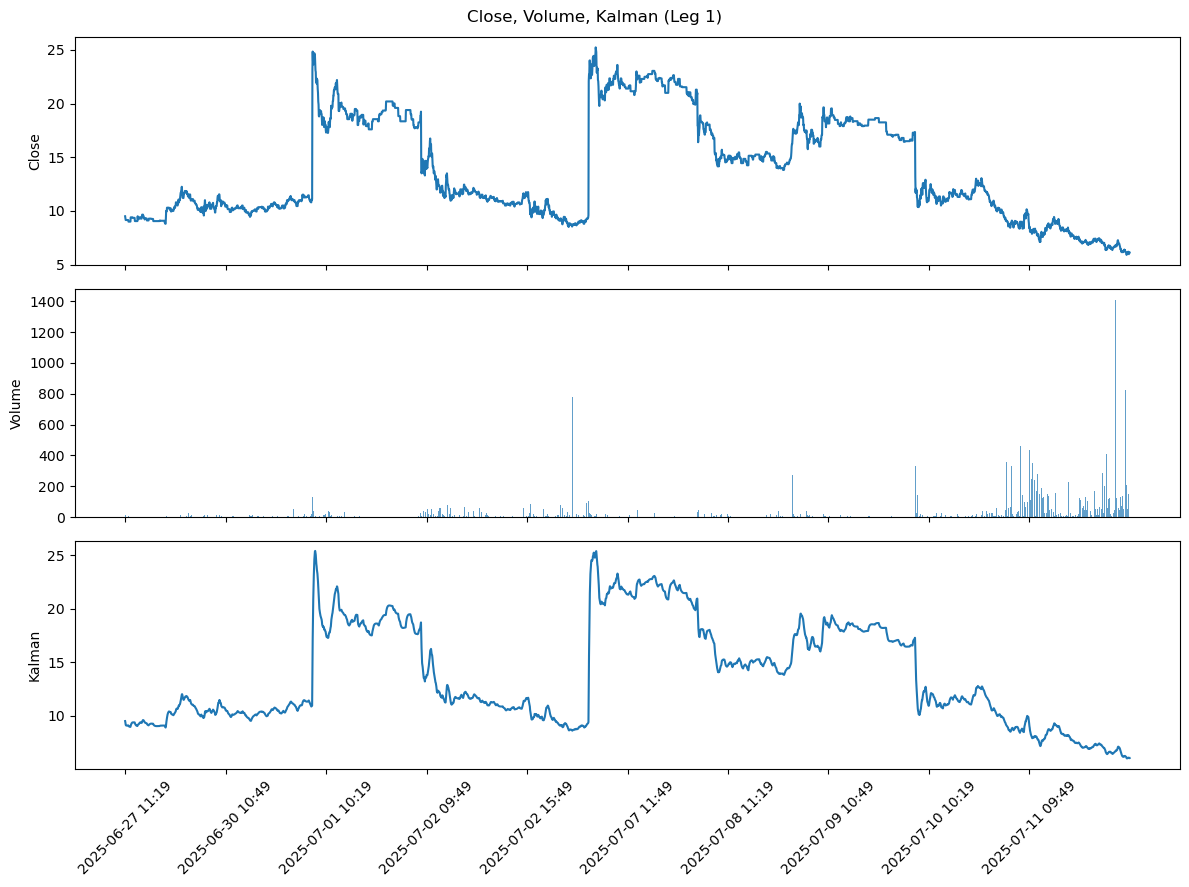

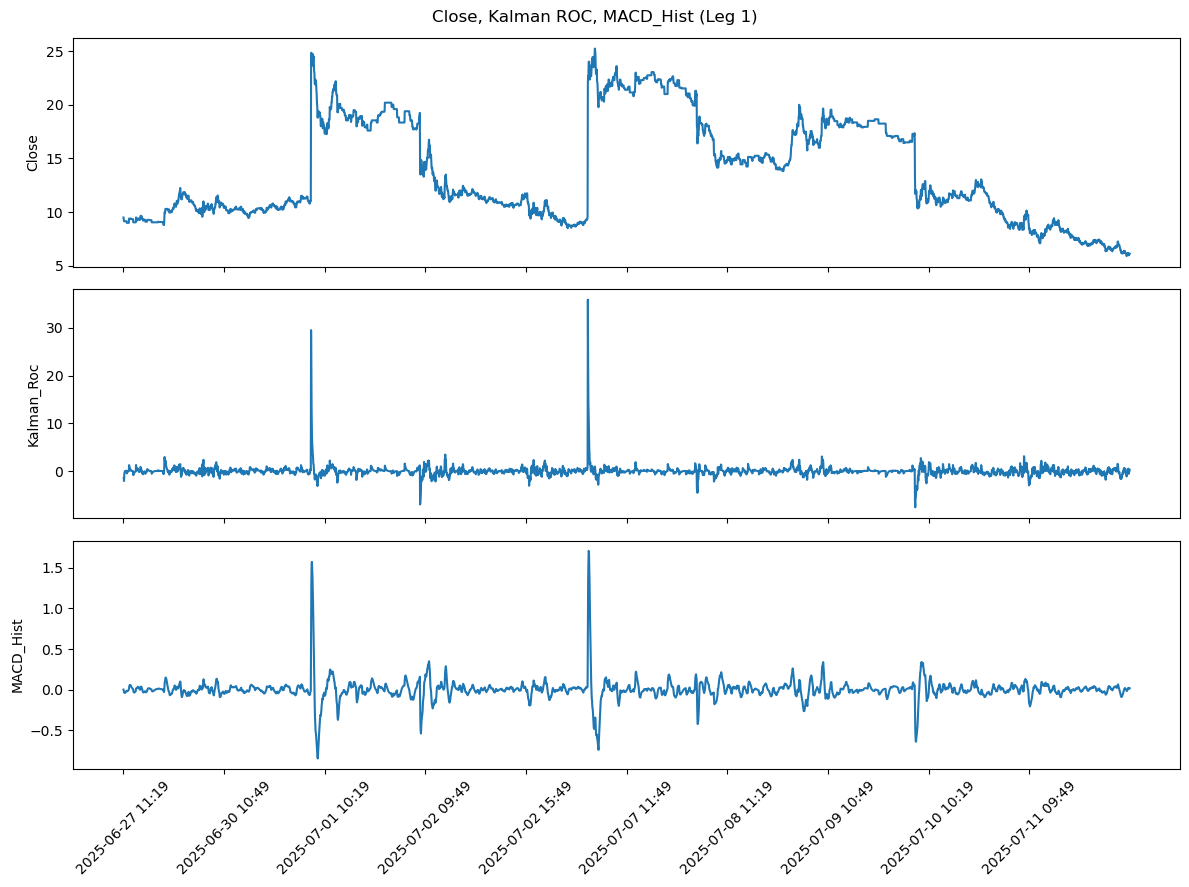

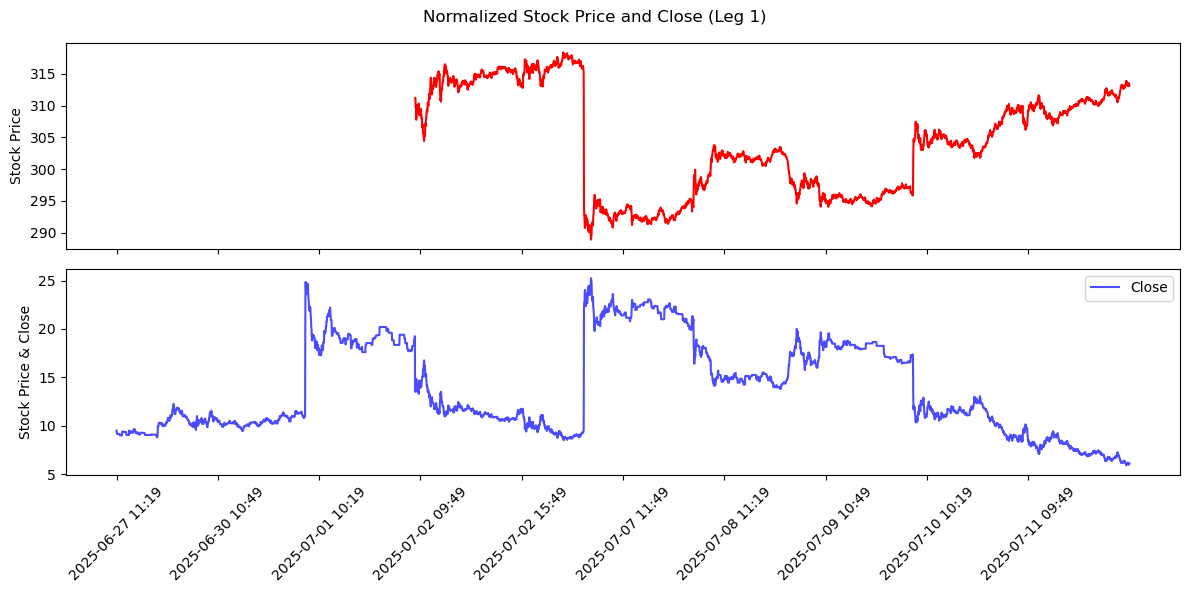

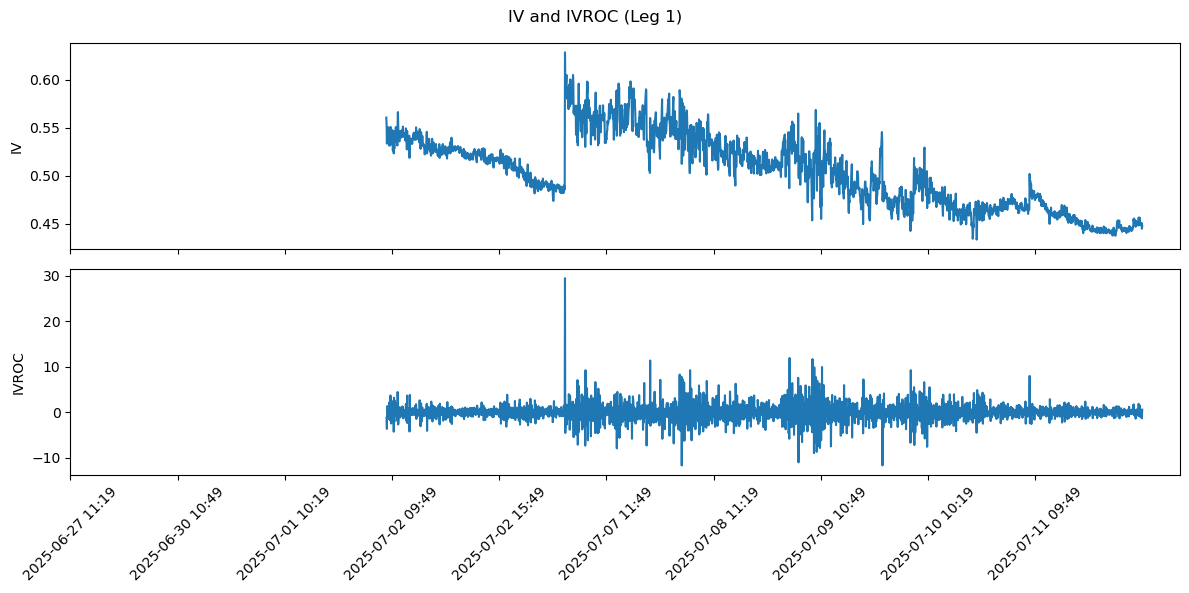

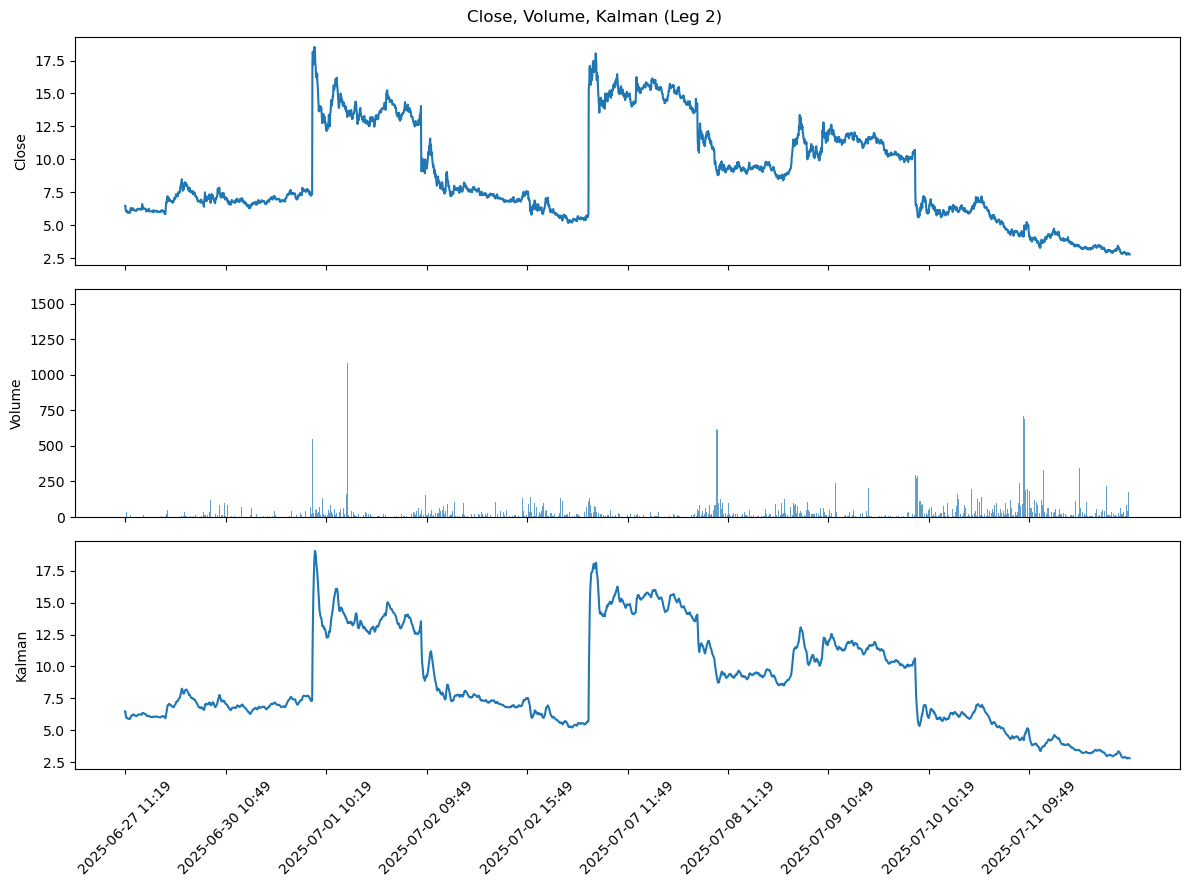

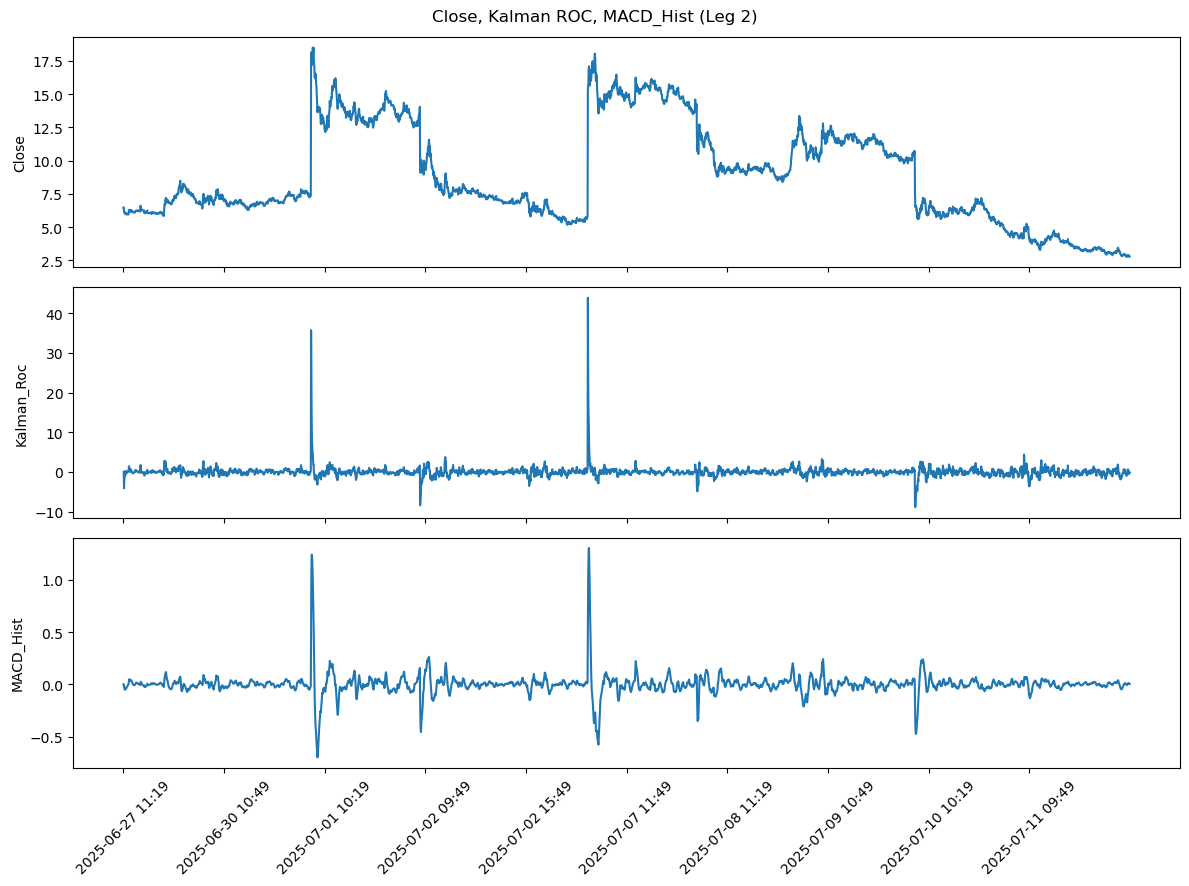

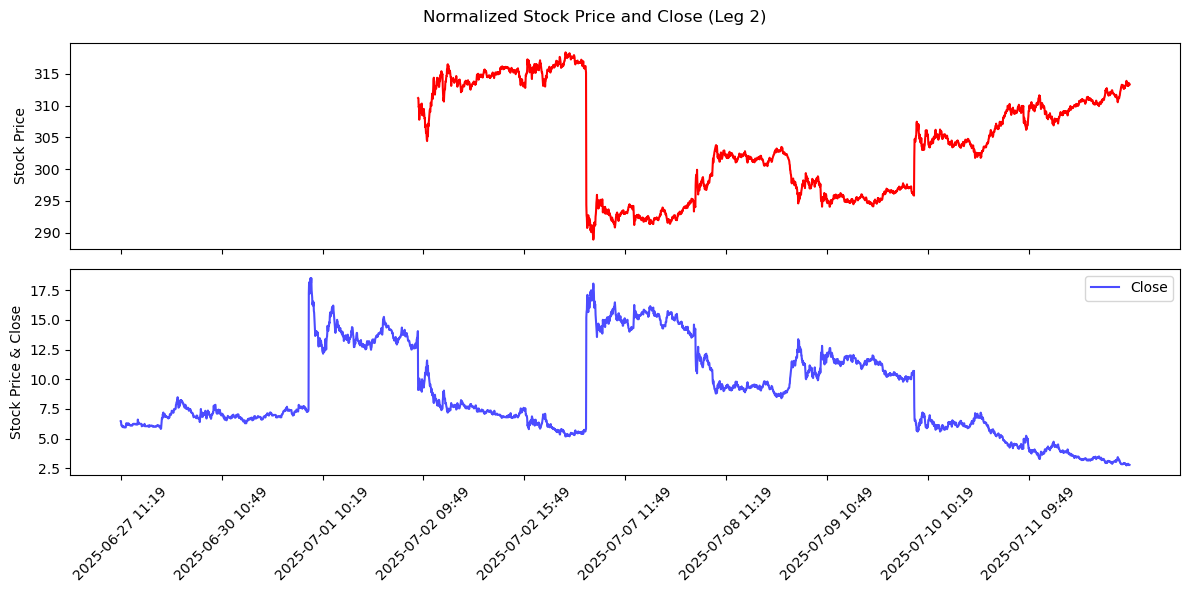

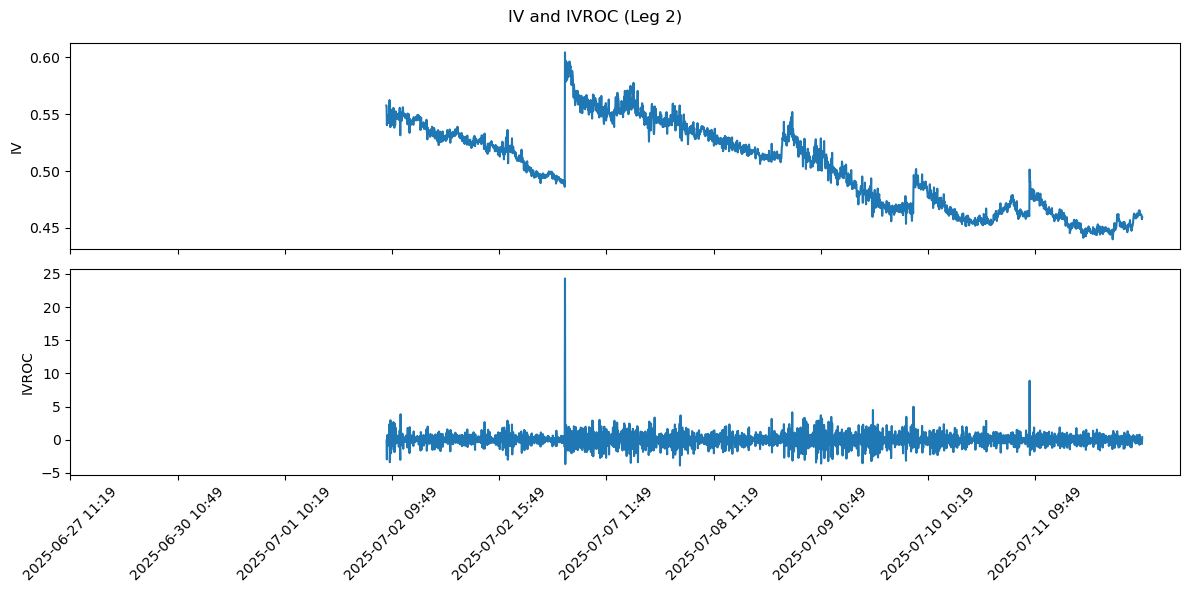

In [20]:
import matplotlib.pyplot as plt

def plot_leg(datafix, leg_label="Leg"):
    datafix_reset = datafix.reset_index()
    datetime_col = datafix_reset.columns[0]
    time_labels = datafix_reset[datetime_col]

    def plot_with_int_index(y_cols, suptitle, kinds=None):
        n = len(y_cols)
        fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
        if n == 1:
            axs = [axs]
        for i, col in enumerate(y_cols):
            kind = 'line' if not kinds else kinds[i]
            if kind == 'bar':
                axs[i].bar(datafix_reset.index, datafix_reset[col], label=col, alpha=0.7)
            else:
                axs[i].plot(datafix_reset.index, datafix_reset[col], label=col)
            axs[i].set_ylabel(col)
        step = max(1, len(time_labels) // 10)
        axs[-1].set_xticks(datafix_reset.index[::step])
        axs[-1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
        plt.suptitle(f"{suptitle} ({leg_label})")
        plt.tight_layout()
        plt.show()

    # 1. Close, Volume (bar), Kalman
    plot_with_int_index(['Close', 'Volume', 'Kalman'], 'Close, Volume, Kalman', kinds=['line', 'bar', 'line'])

    # 2. Close, Kalman_Roc, MACD_Hist (bar)
    plot_with_int_index(['Close', 'Kalman_Roc', 'MACD_Hist'], 'Close, Kalman ROC, MACD_Hist', kinds=['line', 'line', 'line'])

    # 3. Overlay plot: normalized stock price and close
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(datafix_reset.index, datafix['Stock Price'], label='Stock Price', color='red')
    axs[0].set_ylabel('Stock Price')
    axs[1].plot(datafix_reset.index, datafix['Close'], label='Close', color='blue', alpha=0.7)
    axs[1].set_ylabel('Stock Price & Close')
    axs[1].legend()
    step = max(1, len(time_labels) // 10)
    axs[1].set_xticks(datafix_reset.index[::step])
    axs[1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
    plt.suptitle(f'Normalized Stock Price and Close ({leg_label})')
    plt.tight_layout()
    plt.show()

    # 4. IV, IVROC
    plot_with_int_index(['IV', 'IVROC'], 'IV and IVROC')

# Plot for Leg 1
plot_leg(datafix, leg_label="Leg 1")

# Plot for Leg 2
plot_leg(datafix2, leg_label="Leg 2")
